# RQ1 mutation map

We analyze the mutators in wasm-mutate as features. For example, the `CodemotionMutator` has two possible mutations, one, to unroll a loop, two, to invert an if construction. By enabling `code_motion_loops` we will only get information about the mutability of the modules only taking into account the loops in the binary.


## To what extent the sota benchmark is mutable according to wasm-mutate?


### Insights

- A binary can always be mutated by adding a new type or a new function definition
    - To add a bogus function, the binary needs to have a code section, therefore, only 97.29% of the cases can. The remaining 2.71% of the binaries in the while (unfiltered) has no code section. This is probably due to the presence of test suites
- In 96.59% of the cases a peephole mutator can be applied (the same for the code motion). However, this figure takes into account only the high level validation of the mutator. For example, the code mutator only checks for local defined functions. Thus, we need to go deeper and evaluate how many of the instructions per module (% could be) can be in practice parsed and replaced in the relying egraphs. The same for the code mutator.

- The RemoveSection:Custom can be applied to 62.74% of the binaries. This means, that this mutator can be applied without interfiring with the execution of the binary at all. Usually custom sections only appear to provide debug information, such as function names. This leads us to apply reduce to the dataset to evaluate if in fact even after the manual filtering it still be biased by natural obfuscation.

- On the other hand, some mutation can be applied but the generated module could be invalid and thats how wasm-mutate validates the binary. For example, the remove global mutator can be applied, but only at the validation stage, we could notice if the removed global was used or not.

- Interesting, all binaries in the filtered dataset have code section, therefore, we can apply the peephole mutator to all
- Still, RemoveCustomSection can be applied in 32% of the cases. The dataset is probably biased
    - (Insight1)After, some experiments, the reduction works for less than 1% of the cases, therefore the manual filtering is consistent


In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import json
import pandas as pd
import re

resampple = r"sample (\d+)"
is_sampled = r"timeout (true|false)"


def load_mutable_csv(f, rename=""):
    a = pd.read_csv(f"csv/{f}",index_col = 'id')
    
    if rename:
        a.rename(columns = {'mutable_count': rename}, inplace = True)
        
        # Set the sample ratio then
        try:
            a[f"{rename}_sample_ratio"] = a[a[rename] > 0]['class_name'].map(lambda x: 1.0/int(re.search(resampple, x).group(1)))
            
            a[f"{rename}_timeout"] = a[a[rename] > 0]['class_name'].map(lambda x: re.search(is_sampled, x).group(1) == "true")
            
            
        except Exception as e:
            print(e)
            pass
    
    #display(a)
    return a

ratios = [
    
]

peep_features = "select_same_branches.csv container-x-drop-i32.rand.csv container-x-drop-i64.rand.csv container-x-nop.csv f32.add_0.csv f32.add-commutes.csv f32.mul_1.csv f32.mul-commutes.csv f32.use_of_global.csv f64.add_0.csv f64.add-commutes.csv f64.mul_1.csv f64.mul-commutes.csv f64.use_of_global.csv i32.add_0.csv i32.add-1.csv i32.add-associates.csv i32.add-commutes.csv i32.and-1.csv i32.and-commutes.csv i32.eq_0.csv i32.eq-commutes.csv i32.mul-by-2.csv i32.mul-commutes.csv i32.operator_and_commutative.csv i32.operator_or_commutative.csv i32.operator_or_neg_one1.csv i32.operator_or_neg1.csv i32.or-1.csv i32.or-associates.csv i32.or-commutes.csv i32.shl_by_0.csv i32.shl-1.csv i32.shr_s_by_0.csv i32.shr_s-1.csv i32.shr_u_by_0.csv i32.shr_u-1.csv i32.sub_zero.csv i32.sub-1.csv i32.unfold.csv i32.use_of_global.csv i32.xor_0.csv i32.xor-1.csv i32.xor-commutes.csv i64.add_0.csv i64.add-1.csv i64.add-commutes.csv i64.and-1.csv i64.and-commutes.csv i64.eq_0.csv i64.eq-commutes.csv i64.mul_1.csv i64.mul-associates.csv i64.mul-commutes.csv i64.operator_and_commutative.csv i64.operator_or_commutative.csv i64.operator_or_neg1.csv i64.or-1.csv i64.or-commutes.csv i64.shl_by_0.csv i64.shl-1.csv i64.shr_s_by_0.csv i64.shr_s-1.csv i64.shr_u_by_0.csv i64.shr_u-1.csv i64.sub_zero.csv i64.sub-1.csv i64.unfold.csv i64.use_of_global.csv i64.xor_0.csv i64.xor-1.csv i64.xor-commutes.csv remove-data.drop.0.csv remove-data.drop.1.csv remove-drop.csv remove-elem.drop.0.csv remove-elem.drop.1.csv remove-global.set.0.csv remove-global.set.1.csv remove-nop.csv replace-with-f32-1.csv replace-with-f32.rand.csv replace-with-f64-1.csv replace-with-f64.rand.csv replace-with-i32-1.csv replace-with-i32.rand.csv replace-with-i64-1.csv replace-with-i64.rand.csv replace-with-ref-null-extern.csv replace-with-ref-null-func.csv replace-with-v128-1.csv"
peep_features = peep_features.split(" ")
peep_features = [ (f"peep.{f.replace('.csv', '')}", f) for f in peep_features ]
files = (
    [ "codemotion_loops", "code_motion_loops.csv" ],
    [ "codemotion_ifs", "code_motion_ifs.csv" ],
    [ "modify_custom_section_data", "modify_custom_section_data.csv" ],
    [ "remove_exports", "remove_exports.csv" ],
    [ "remove_function", "remove_function.csv" ],
    [ "remove_table", "remove_item_table.csv" ],
    [ "remove_global", "remove_item_global.csv" ],
    [ "remove_memory", "remove_item_memory.csv" ],
    [ "remove_tag", "remove_item_tag.csv" ],
    [ "remove_data", "remove_item_data.csv" ],
    [ "remove_element", "remove_item_element.csv" ],
    [ "remove_item_function", "remove_item_function.csv" ],
    [ "snip_function", "snip_function.csv" ],
    [ "modify_data", "modify_data.csv" ],
    
    # Peep hole level
    *peep_features
)
alldf = pd.DataFrame()

for n, f in files:
    print(n)
    df = load_mutable_csv(f, n)
    alldf = pd.concat([df, alldf], axis=1)

# Replace 0 by non mutable :|
alldf=alldf.fillna(0)
alldf = alldf.loc[:,~alldf.columns.duplicated()].copy()

display(alldf)

alldf.to_csv("all.csv")

print(ratios)

codemotion_loops
'class_name'
codemotion_ifs
'class_name'
modify_custom_section_data
'class_name'
remove_exports
'class_name'
remove_function
'class_name'
remove_table
'class_name'
remove_global
'class_name'
remove_memory
'class_name'
remove_tag
'class_name'
remove_data
'class_name'
remove_element
'class_name'
remove_item_function
snip_function
'class_name'
modify_data
'class_name'
peep.select_same_branches
peep.container-x-drop-i32.rand
peep.container-x-drop-i64.rand
peep.container-x-nop
peep.f32.add_0
peep.f32.add-commutes
peep.f32.mul_1
peep.f32.mul-commutes
peep.f32.use_of_global
peep.f64.add_0
peep.f64.add-commutes
peep.f64.mul_1
peep.f64.mul-commutes
peep.f64.use_of_global
peep.i32.add_0
peep.i32.add-1
peep.i32.add-associates
peep.i32.add-commutes
peep.i32.and-1
peep.i32.and-commutes
peep.i32.eq_0
peep.i32.eq-commutes
peep.i32.mul-by-2
peep.i32.mul-commutes
peep.i32.operator_and_commutative
peep.i32.operator_or_commutative
peep.i32.operator_or_neg_one1
peep.i32.operator_or_neg1
p

,num_tags,num_functions,num_globals,num_tables,num_elements,num_data,num_types,num_memory,num_instructions,class_name,...,remove_data,remove_tag,remove_memory,remove_global,remove_table,remove_function,remove_exports,modify_custom_section_data,codemotion_ifs,codemotion_loops
id,,,,,,,,,,,,,,,,,,,,,
00008799c04b4f111d28331ef77c387fb2bd6724c9ce88a80f30cd320c044c29.wasm,0.0,19.0,3.0,1.0,1.0,0.0,10.0,1.0,1751.0,none,...,0,0,0,0,0,0.0,0,0,0,20
000415b2639c960e039299fde2a52e7e9c692c212c1fa6ca4701eec637ff6a30.wasm,0.0,37.0,6.0,0.0,1.0,0.0,10.0,0.0,28339.0,none,...,0,0,0,1,0,0.0,0,0,264,61
000e01741a75cf7a3d9afc0f4950c220c67188a7c1434bb6699654e00d07c1da.wasm,0.0,72.0,27.0,1.0,1.0,0.0,16.0,1.0,14859.0,none,...,0,0,0,0,0,0.0,0,2,0,105
00189ff4eeb814ffa662649ba6859c004036580fccc2b83862cda60f5737d5d1.wasm,0.0,37.0,0.0,1.0,1.0,0.0,19.0,1.0,5313.0,none,...,0,0,0,0,0,0.0,0,0,0,29
0018e8f82de999af365dfc57d0bbe06d5d08eaf791d31f59af0eecd53d363efa.wasm,0.0,25.0,0.0,1.0,1.0,0.0,11.0,1.0,2454.0,none,...,0,0,0,0,0,0.0,0,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01cd2c178b57d07f45132be806c96154c28b51f5959faa5b9309089aa286bc23.wasm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0.0,0,0,311874,30133
31fa012442fd637fca221db4fda94262e99759ab9667147cbedde083aabcc065.wasm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,1,0,0,0.0,0,1,0,0
52d00610949d18365422159c57b372c6d567517446a21fc02c274f35d675d34c.wasm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0.0,0,0,181070,29539


[]


61


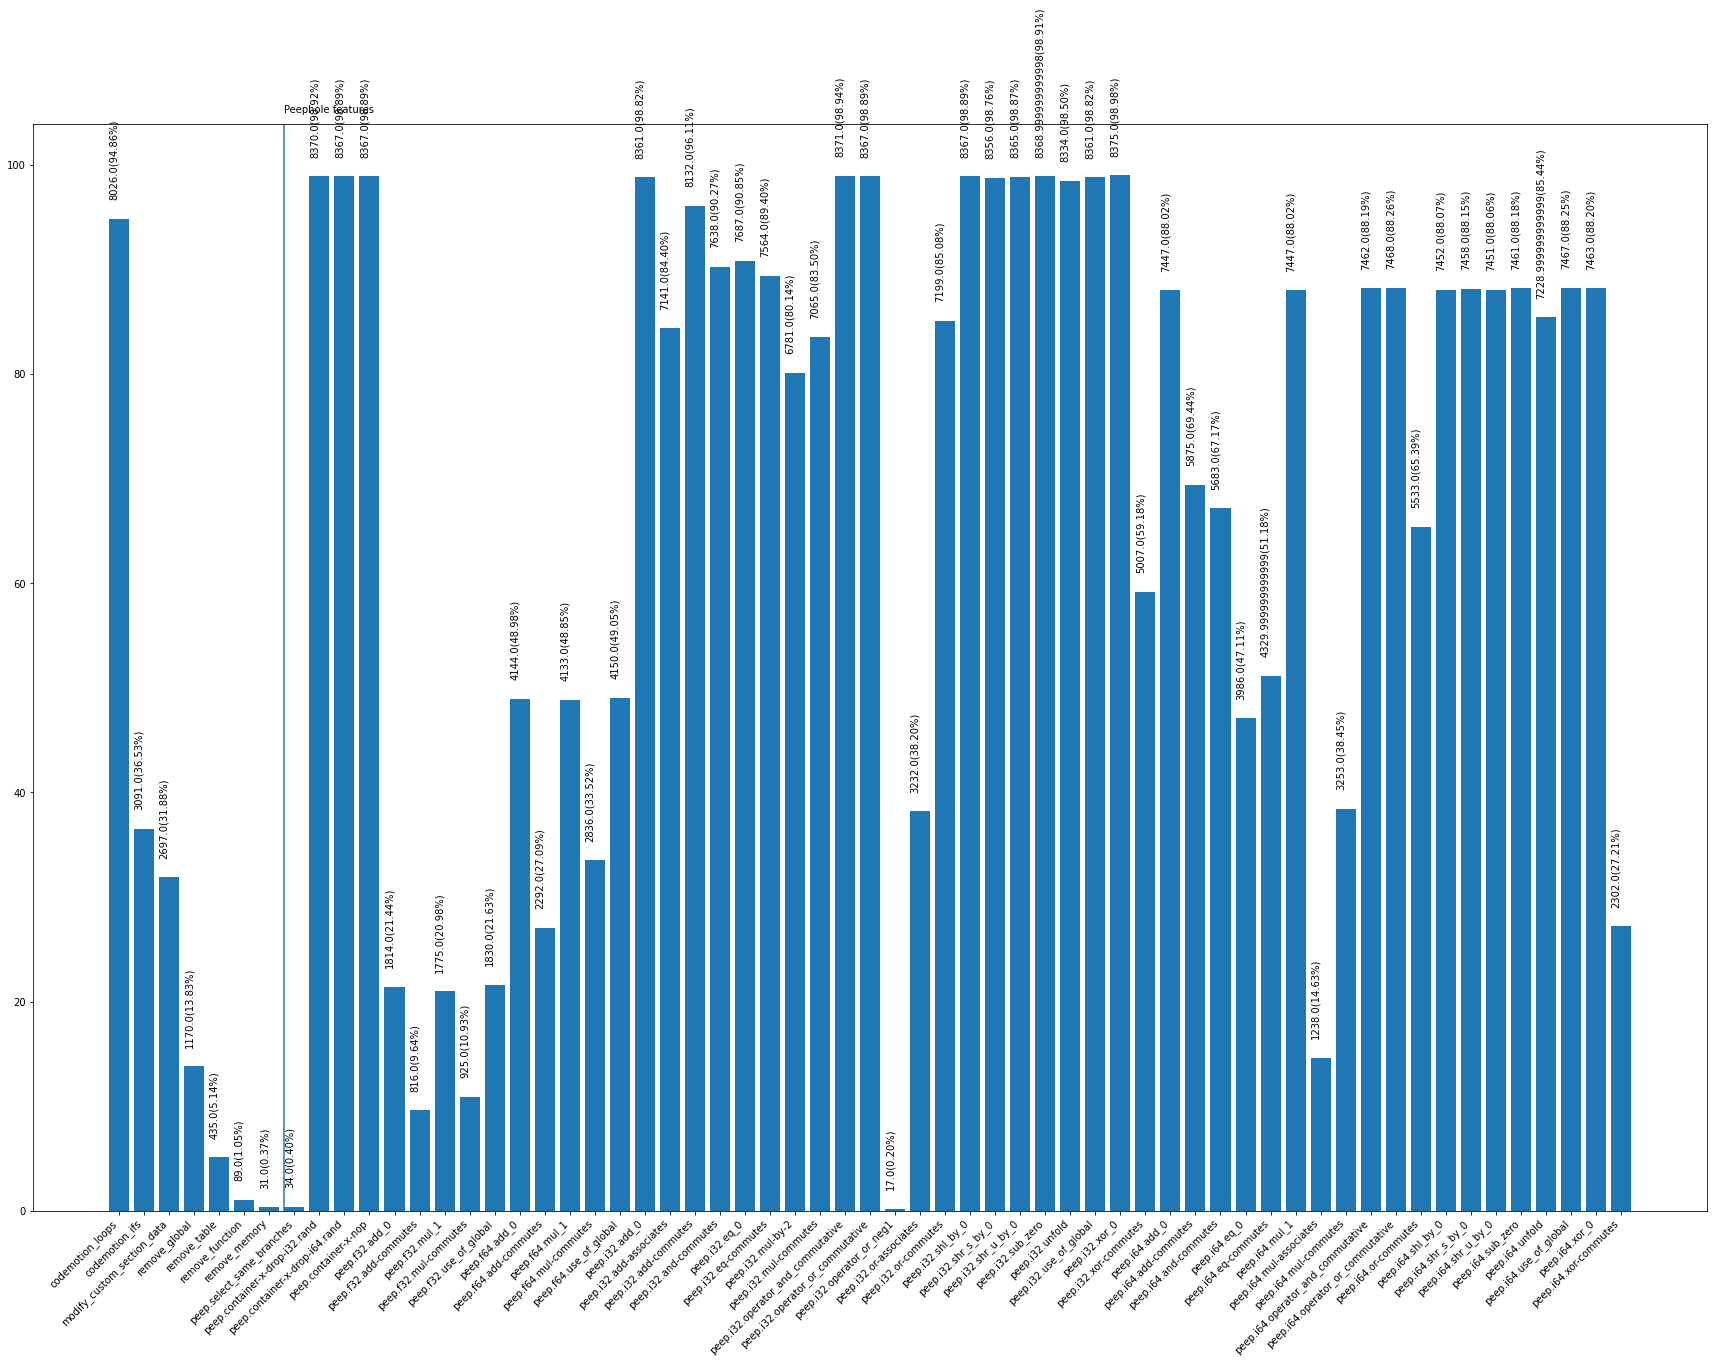

In [17]:
# import and set figure size
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [30, 20]

total = len(alldf)
ratios = [ (x, 100*len(alldf[alldf[x] > 0][x])/total) for x in [y[0] for y in files] ]

ratios = sorted(ratios, key= lambda x: x[1] if "peep" not in x[0] else -1, reverse=True)

# Filter out no applicable mutators
ratios = [ r for r in ratios if r[1] > 0]
print(len(ratios))

bars = plt.bar([
    x[0] for x in ratios
], [x[1] for x in ratios])
plt.xticks(rotation=45, ha='right')

peep_from = 7 

for i, (b, r) in enumerate(zip(bars, ratios)):
    x,y = b.xy
    if i == peep_from:
        plt.axvline(x=x)
        plt.text(x, 105, f"Peephole features")
    y = y + r[1] + 2
    plt.text(x, y, f"{r[1]*len(alldf)/100}({r[1]:.2f}%)", rotation=90)

plt.savefig("mutable.png")

The plot is divided by two, the left part contains the high/middle level mutators and the right part the peephole (most fine-grained) mutators.

The previous plot is organized by feature. 
- 94.86% of the binaries contain loops. Thus the `loop unroll` mutator can be applied. 
- 233 binaries can be reduced by removing unused/unxerpoted functions.
- 435 binaries can be reduced by removing unused/unexported tables.
- 1170 binaries contain globals that can be removed.
- 31 binaries can remove some of its memory.

- The select-invert is "complementaria" with the codemotion_ifs, so compilers prefer to use select instead of if else.

What is the difference between `remove_item_function` and `remove_function` ? TODO

## Mutability indexes

The idea is to get the mutability ratio of each mutator. The mutability ratio is the value of $$ \frac{|applicable\ targets|}{|total\ instructions|} $$ . For example, if the `unroll loop` can be applied x times, this means that we have x out of N intructions that are mutable by this mutator. In the case of the peephole, it can be seen as the number of instruction for which we can build an egraph.

We will use this index to create the feature selection of swarm-testing. **It is more probable that a mutator offers an interesting "test" if it has a high mutation ratio**.



,num_tags,num_functions,num_globals,num_tables,num_elements,num_data,num_types,num_memory,num_instructions,modify_data,...,remove_tag,remove_memory,remove_global,remove_table,remove_function,remove_exports,modify_custom_section_data,codemotion_ifs,codemotion_loops,unroll_mutability
id,,,,,,,,,,,,,,,,,,,,,
00008799c04b4f111d28331ef77c387fb2bd6724c9ce88a80f30cd320c044c29.wasm,0,19,3,1,1,0,10,1,1751,0,...,0,0,0,0,0.0,0,0,0,20,0.011422
006857e368dc41aa007976668089aed736a3e2f9a337d08fd4bc9011400b6ff9.wasm,0,51,0,1,1,0,22,1,6786,0,...,0,0,0,0,0.0,0,0,0,29,0.004274
009f9b5840c0e7cb99d065b70bd2c1d615deb638e21278377045c9523b98dc40.wasm,0,100,0,1,1,0,30,1,27473,0,...,0,0,0,0,0.0,0,0,0,228,0.008299
010414721cfad765a9213520757d38c5194b4ff581ab919d7b4fe38b9b7c9d51.wasm,0,341,3,1,1,0,23,1,24031,0,...,0,0,0,0,0.0,0,0,0,97,0.004036
013cb31eb5fc08c97960054f0b6d404658cb757b96c70a924712534aad13cc3f.wasm,0,255,3,1,1,0,37,1,87366,0,...,0,0,0,0,0.0,0,0,0,497,0.005689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe6838aeb7debe2c7c820258ead5f0e8798bb33742e31b238da70cc9675bdf80.wasm,0,51,3,1,1,0,14,1,12219,0,...,0,0,0,0,0.0,0,2,0,93,0.007611
fedbe9ee59f69748f22d1f66560851cdf3fc6fd4230ec54a63fd7adaa992047d.wasm,0,80,27,1,1,0,16,1,14930,0,...,0,0,0,0,0.0,0,2,0,103,0.006899
ff2470e3ab3b9ae36b2af0ef27961d49f0542f5697229241b5d7107766cc854c.wasm,0,74,27,1,1,0,16,1,15299,0,...,0,0,0,0,0.0,0,2,0,109,0.007125


(array([435.,   5.,   3.,   2.,   2.,   6.,   4.,   7.,   9.,  12.,   7.,
          9.,   5.,   8.,   7.,   9.,  16.,   6.,  15.,  15.,  14.,  22.,
         48.,  38.,  24.,  23.,  33.,  30.,  24.,  29.,  32.,  41.,  40.,
         51.,  65.,  50.,  53.,  75.,  53.,  26.,  53.,  85.,  64.,  72.,
         68.,  62.,  68.,  66.,  72.,  80.,  82.,  70.,  77.,  81.,  87.,
        123., 108.,  86.,  71., 109.,  94., 102.,  89.,  76.,  98.,  81.,
         79.,  86.,  98.,  88.,  86.,  84.,  91.,  80., 107.,  90., 112.,
        103.,  87.,  72.,  71.,  83.,  77.,  81.,  74.,  65.,  68.,  82.,
         63.,  63.,  78.,  81.,  85.,  88., 150., 171., 153., 160.,  89.,
         99.,  88., 116., 116., 131.,  95.,  91.,  48.,  55.,  57.,  58.,
         38.,  42.,  29.,  40.,  35.,  30.,  16.,  21.,  26.,  16.,  16.,
         14.,  11.,  11.,  13.,   5.,  11.,   6.,   9.,  14.,   9.,  10.,
          2.,   8.,   6.,   9.,  11.,   4.,   2.,  10.,   8.,   6.,   6.,
          6.,   6.,   5.,   3.,   5., 

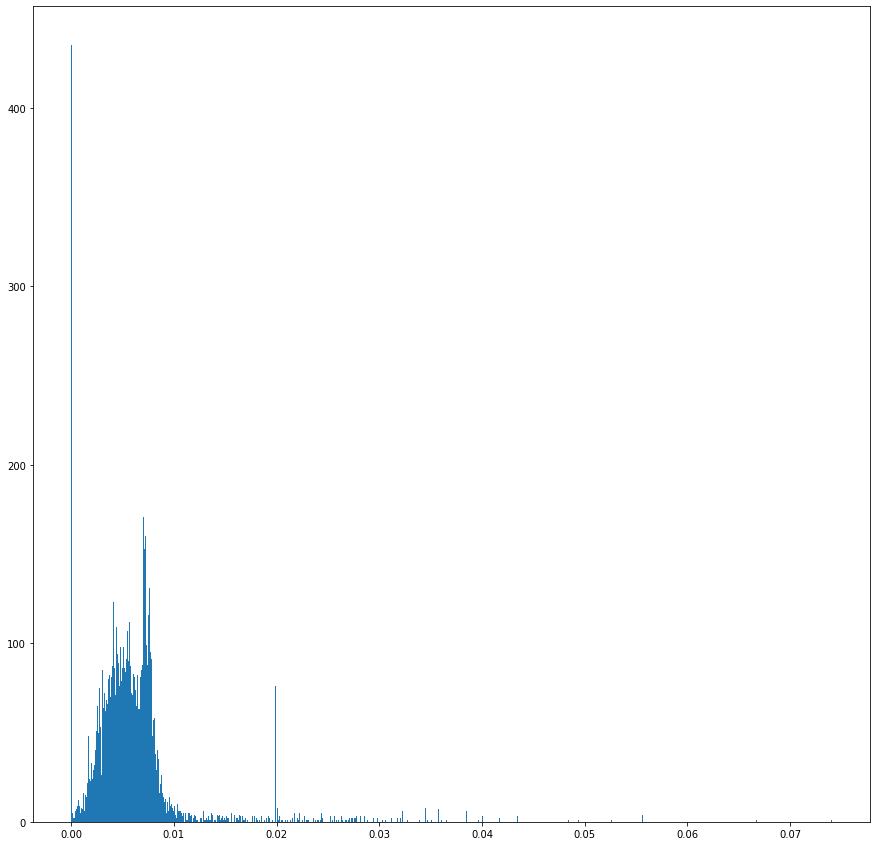

In [65]:
# get mutability_ratio for unroll
alldf['unroll_mutability'] = alldf['codemotion_loops']/alldf['num_instructions']
display(alldf)

plt.hist(alldf[alldf['num_instructions'] > 0]['unroll_mutability'], bins=1000)


There is a normal distribution in the 0.5% of mutability for the unroll mutator. 

**The question now is: So, this feature needs to be uniformally selected based on the average mutability ({0, 1}) or based on the mutability ratio using a gaussian distribution ?**

,num_tags,num_functions,num_globals,num_tables,num_elements,num_data,num_types,num_memory,num_instructions,modify_data,...,remove_global,remove_table,remove_function,remove_exports,modify_custom_section_data,codemotion_ifs,codemotion_loops,unroll_mutability,ifs_mutability,global_removal_mutability
id,,,,,,,,,,,,,,,,,,,,,
00008799c04b4f111d28331ef77c387fb2bd6724c9ce88a80f30cd320c044c29.wasm,0,19,3,1,1,0,10,1,1751,0,...,0,0,0.0,0,0,0,20,0.011422,0.000000,0.000000
006857e368dc41aa007976668089aed736a3e2f9a337d08fd4bc9011400b6ff9.wasm,0,51,0,1,1,0,22,1,6786,0,...,0,0,0.0,0,0,0,29,0.004274,0.000000,NaN
009f9b5840c0e7cb99d065b70bd2c1d615deb638e21278377045c9523b98dc40.wasm,0,100,0,1,1,0,30,1,27473,0,...,0,0,0.0,0,0,0,228,0.008299,0.000000,NaN
010414721cfad765a9213520757d38c5194b4ff581ab919d7b4fe38b9b7c9d51.wasm,0,341,3,1,1,0,23,1,24031,0,...,0,0,0.0,0,0,0,97,0.004036,0.000000,0.000000
013cb31eb5fc08c97960054f0b6d404658cb757b96c70a924712534aad13cc3f.wasm,0,255,3,1,1,0,37,1,87366,0,...,0,0,0.0,0,0,0,497,0.005689,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe6838aeb7debe2c7c820258ead5f0e8798bb33742e31b238da70cc9675bdf80.wasm,0,51,3,1,1,0,14,1,12219,0,...,0,0,0.0,0,2,0,93,0.007611,0.000000,0.000000
fedbe9ee59f69748f22d1f66560851cdf3fc6fd4230ec54a63fd7adaa992047d.wasm,0,80,27,1,1,0,16,1,14930,0,...,0,0,0.0,0,2,0,103,0.006899,0.000000,0.000000
ff2470e3ab3b9ae36b2af0ef27961d49f0542f5697229241b5d7107766cc854c.wasm,0,74,27,1,1,0,16,1,15299,0,...,0,0,0.0,0,2,0,109,0.007125,0.000000,0.000000


(array([5.37e+03, 6.00e+00, 8.00e+00, 1.30e+01, 7.00e+00, 1.60e+01,
        8.00e+00, 6.00e+00, 1.10e+01, 7.00e+00, 1.40e+01, 4.00e+00,
        5.00e+00, 4.00e+00, 0.00e+00, 4.00e+00, 1.20e+01, 3.00e+00,
        1.00e+00, 1.00e+00, 3.00e+00, 2.00e+00, 1.00e+00, 7.00e+00,
        3.00e+00, 1.00e+00, 0.00e+00, 5.00e+00, 4.00e+00, 0.00e+00,
        8.00e+00, 6.00e+00, 2.00e+00, 2.00e+00, 0.00e+00, 4.00e+00,
        4.00e+00, 0.00e+00, 2.00e+00, 3.00e+00, 6.00e+00, 2.00e+00,
        2.00e+00, 2.00e+00, 4.00e+00, 3.00e+00, 1.10e+01, 6.00e+00,
        2.00e+00, 4.00e+00, 2.00e+00, 8.00e+00, 2.00e+00, 5.00e+00,
        1.00e+00, 1.00e+00, 3.00e+00, 0.00e+00, 2.00e+00, 2.00e+00,
        2.00e+00, 5.00e+00, 1.00e+00, 2.00e+00, 2.00e+00, 8.00e+00,
        1.30e+01, 9.00e+00, 1.00e+00, 1.00e+00, 3.00e+00, 7.00e+00,
        1.00e+00, 1.00e+00, 8.00e+00, 4.00e+00, 6.00e+00, 5.00e+00,
        5.00e+00, 5.00e+00, 2.00e+00, 4.00e+00, 7.00e+00, 8.00e+00,
        4.00e+00, 1.20e+01, 9.00e+00, 9.00e+00, 

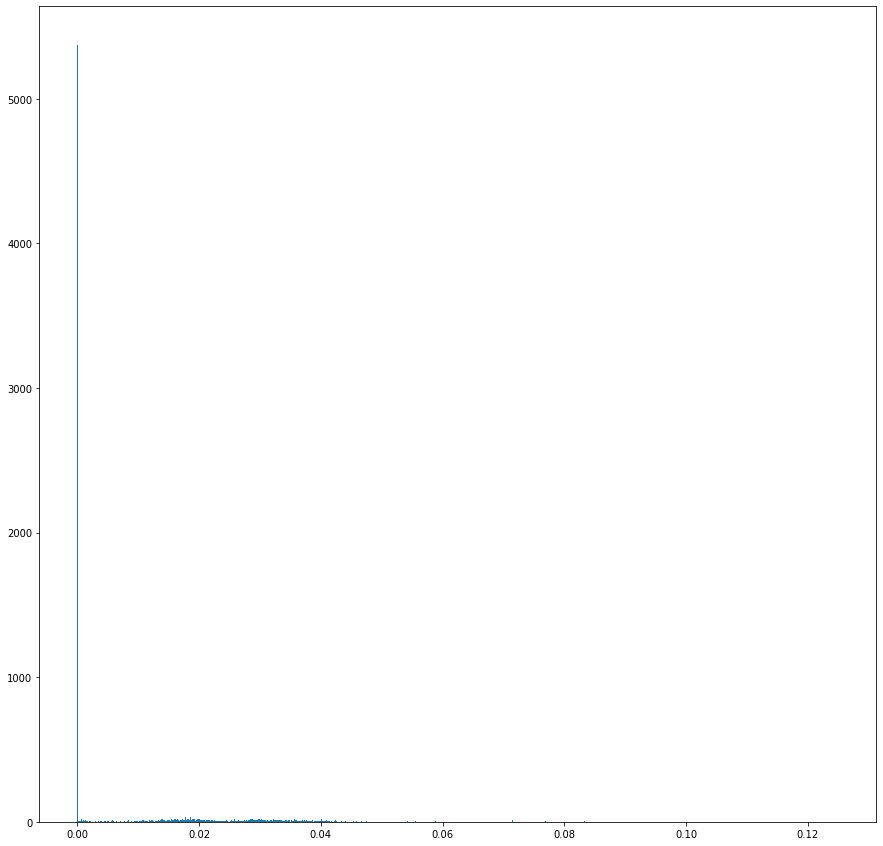

In [69]:
# get mutability_ratio for if complement
alldf['ifs_mutability'] = alldf['codemotion_ifs']/alldf['num_instructions']
alldf.fillna(0)
display(alldf)

plt.hist(alldf['ifs_mutability'], bins=1000)

In the case of the `if completement` mutator, it seems like an uniform distribution. However, it is interesting how this construction is less used. What is reason for that? Maybe compilers prefer to use `select` constructions instead. For our sake, the egraph also has a `select` invert rule, so, we cover both cases. It would be interesting to see the presence of `select` instructions.


BTW, there is no point on getting mutability index for the high level mutators, such as the `add_function_mutator`. However, this makes sense for middle level mutators. For example, to remove a function, it should be $$ \frac{|removable\ functions|}{|total\ functions|} $$

,num_tags,num_functions,num_globals,num_tables,num_elements,num_data,num_types,num_memory,num_instructions,class_name,...,remove_tag,remove_memory,remove_global,remove_table,remove_function,remove_exports,modify_custom_section_data,codemotion_ifs,codemotion_loops,global_removal_mutability
id,,,,,,,,,,,,,,,,,,,,,
000415b2639c960e039299fde2a52e7e9c692c212c1fa6ca4701eec637ff6a30.wasm,0.0,37.0,6.0,0.0,1.0,0.0,10.0,0.0,28339.0,none,...,0,0,1,0,0.0,0,0,264,61,0.166667
001f1e270faf29ba8be102fd3de18f55f39d16f8bc84a4388b5dd5f302ea9d7c.wasm,0.0,62.0,3.0,1.0,1.0,0.0,28.0,1.0,9854.0,none,...,0,0,0,0,0.0,0,0,0,53,0.000000
005ef92c4f9c4d606d32a32aa3e513ca7f258d704267bb4573f01bd4bf0e73b4.wasm,0.0,135.0,5.0,1.0,1.0,0.0,40.0,1.0,33385.0,none,...,0,0,0,0,0.0,0,0,0,257,0.000000
00986a2e9791b25efc4c8681978dfef0af40600251cf688dda3b0e5e6b489438.wasm,0.0,220.0,1.0,0.0,1.0,0.0,42.0,0.0,18668.0,none,...,0,0,0,0,0.0,0,0,411,139,0.000000
009c0ec98624370de804eec7af5189f2e6774a276d3ddb4fe39c59387de8db72.wasm,0.0,99.0,3.0,1.0,1.0,0.0,36.0,1.0,17334.0,none,...,0,0,0,0,0.0,0,0,0,103,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fddd082393fbc1c31ab5cc85a63d905311c416a4f7ca4de4ada01dab843221f2.wasm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,1.0,0,0,0,39,NaN
fe20aa841af8713203ca20b771d45e479f1e66d5c0948d2eacf4375bce0244ed.wasm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.0,0,0,0,176,NaN
fe6838aeb7debe2c7c820258ead5f0e8798bb33742e31b238da70cc9675bdf80.wasm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.0,0,2,0,93,NaN


(array([1.688e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 9.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 9.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.700e+01, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+0

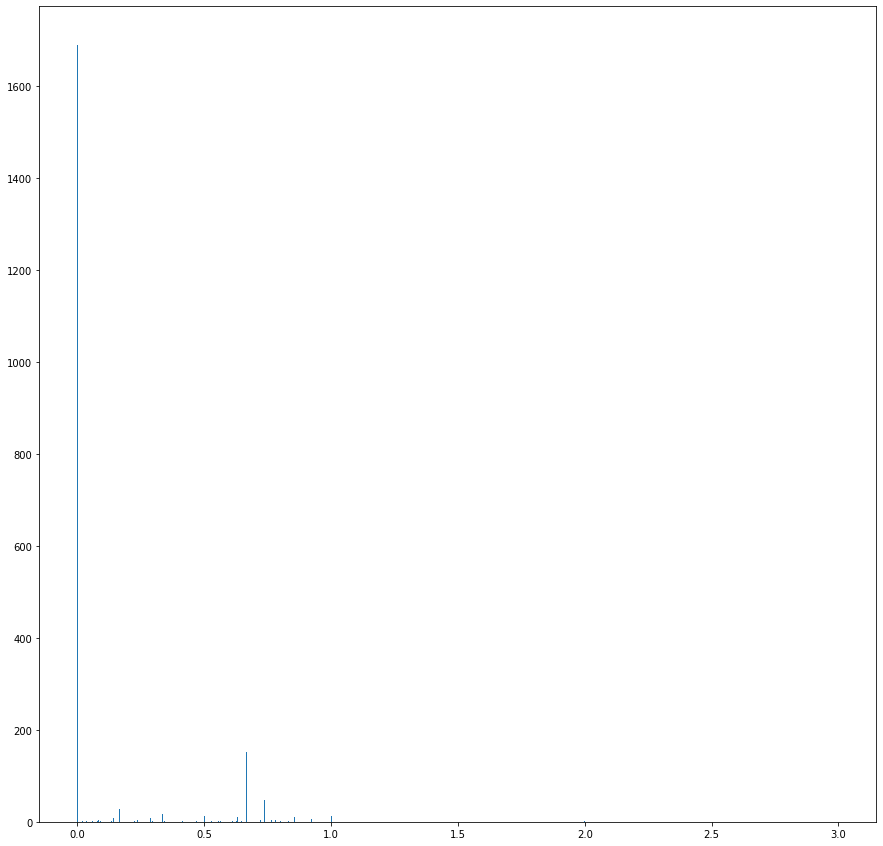

In [120]:
alldf['global_removal_mutability'] = alldf['remove_global']/alldf['num_globals']
alldf.fillna(0)
display(alldf)

plt.hist(alldf[alldf['num_globals'] > 0]['global_removal_mutability'], bins=1000)

In [139]:
# The same for a peephole_based one
i64 = load_mutable_csv("i64.mul-by-8.csv", "i64.mul-by-8")
i64_true = i64[i64["i64.mul-by-8"] > 0]

i64_true = i64_true.copy()
display(i64_true)
i64_true['mutability'] = (i64_true["i64.mul-by-8"]/i64_true["i64.mul-by-8_sample_ratio"])/i64_true['num_instructions']


display(i64_true)

,num_tags,num_functions,num_globals,num_tables,num_elements,num_data,num_types,num_memory,num_instructions,class_name,i64.mul-by-8,i64.mul-by-8_sample_ratio,i64.mul-by-8_timeout
id,,,,,,,,,,,,,
001b9d3ccd59feccaf0f1b49d0713df31f529e3dbd5a497420287e6f1507f45d.wasm,0,9891,8,1,1,0,12,1,4450462,PeepholeMutator::new(2) sample 10 timeout true,37,0.10,True
017d9435c5bc89de62b5893a620b915bc4ea6d02670872ef287e193434dafc69.wasm,0,850,3,1,1,0,39,1,152395,PeepholeMutator::new(2) sample 10 timeout false,3,0.10,False
01b2c15b424692cb914d20e8d2d4d43185334a681af7ad5b57ed91c80aec0a5e.wasm,0,71,0,1,1,0,23,1,15289,PeepholeMutator::new(2) sample 10 timeout false,1,0.10,False
01f94956c13b5ea69b808cc149808536af5479706112ee38a152abb9759e59b4.wasm,0,1937,3,1,1,0,62,1,566113,PeepholeMutator::new(2) sample 10 timeout true,1,0.10,True
023094232c46292e09d7e9c2bd43ac40aa1d73eb8906d3505a01a8247aca7e54.wasm,0,4241,2,0,1,0,130,0,1352822,PeepholeMutator::new(2) sample 10 timeout true,1,0.10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd15be3f64fb9473b6bccef3e1c64b9921471fe435cf7a5e6e66b609f1e2fb07.wasm,0,4538,8,1,1,0,12,1,2145789,PeepholeMutator::new(2) sample 10 timeout true,45,0.10,True
fd9d4d597186c48948687330b76271e10ecada2908c91b4a7f54eca59a961555.wasm,0,6015,1,0,1,0,158,0,1294874,PeepholeMutator::new(2) sample 10 timeout true,1,0.10,True
fda6788bea0de363bf1289f75a65f85079b9a0aa4fcdf1d311ef3b44a3ce12be.wasm,0,3397,8,1,1,0,12,1,1526170,PeepholeMutator::new(2) sample 10 timeout true,59,0.10,True


,num_tags,num_functions,num_globals,num_tables,num_elements,num_data,num_types,num_memory,num_instructions,class_name,i64.mul-by-8,i64.mul-by-8_sample_ratio,i64.mul-by-8_timeout,mutability
id,,,,,,,,,,,,,,
001b9d3ccd59feccaf0f1b49d0713df31f529e3dbd5a497420287e6f1507f45d.wasm,0,9891,8,1,1,0,12,1,4450462,PeepholeMutator::new(2) sample 10 timeout true,37,0.10,True,0.000083
017d9435c5bc89de62b5893a620b915bc4ea6d02670872ef287e193434dafc69.wasm,0,850,3,1,1,0,39,1,152395,PeepholeMutator::new(2) sample 10 timeout false,3,0.10,False,0.000197
01b2c15b424692cb914d20e8d2d4d43185334a681af7ad5b57ed91c80aec0a5e.wasm,0,71,0,1,1,0,23,1,15289,PeepholeMutator::new(2) sample 10 timeout false,1,0.10,False,0.000654
01f94956c13b5ea69b808cc149808536af5479706112ee38a152abb9759e59b4.wasm,0,1937,3,1,1,0,62,1,566113,PeepholeMutator::new(2) sample 10 timeout true,1,0.10,True,0.000018
023094232c46292e09d7e9c2bd43ac40aa1d73eb8906d3505a01a8247aca7e54.wasm,0,4241,2,0,1,0,130,0,1352822,PeepholeMutator::new(2) sample 10 timeout true,1,0.10,True,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd15be3f64fb9473b6bccef3e1c64b9921471fe435cf7a5e6e66b609f1e2fb07.wasm,0,4538,8,1,1,0,12,1,2145789,PeepholeMutator::new(2) sample 10 timeout true,45,0.10,True,0.000210
fd9d4d597186c48948687330b76271e10ecada2908c91b4a7f54eca59a961555.wasm,0,6015,1,0,1,0,158,0,1294874,PeepholeMutator::new(2) sample 10 timeout true,1,0.10,True,0.000008
fda6788bea0de363bf1289f75a65f85079b9a0aa4fcdf1d311ef3b44a3ce12be.wasm,0,3397,8,1,1,0,12,1,1526170,PeepholeMutator::new(2) sample 10 timeout true,59,0.10,True,0.000387


(array([67., 52., 42., 14., 26., 18., 13., 31., 11., 12., 16.,  8., 14.,
         5.,  5.,  4.,  7.,  4.,  4.,  4.,  4.,  2.,  7.,  2.,  2.,  3.,
         4.,  5.,  7.,  2.,  2.,  1.,  3.,  4.,  0.,  8.,  1.,  1.,  1.,
         2.,  4.,  5.,  3.,  2.,  2.,  0.,  0.,  2.,  0.,  2.,  2.,  1.,
         3.,  3.,  4.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  3.,  0.,  1.,
         1.,  3.,  1.,  1.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.

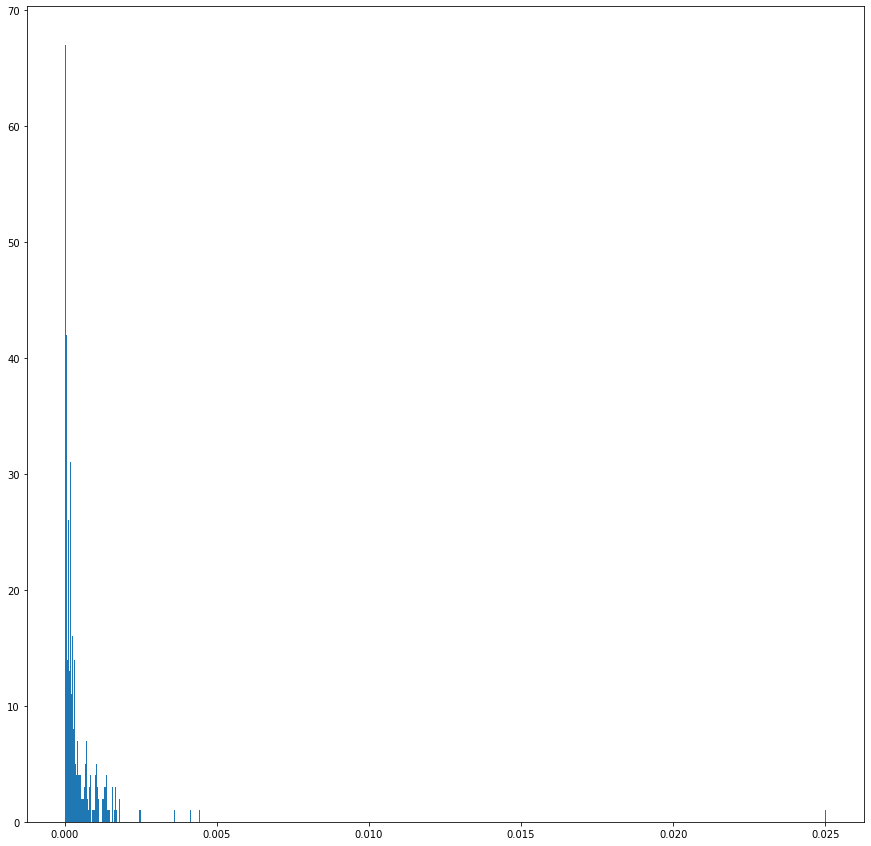

In [140]:
plt.hist(i64_true['mutability'], bins=1000)

In [6]:
drop = load_mutable_csv("i32.drop-x.csv", "i32.drop-x")
display(drop)


,num_tags,num_functions,num_globals,num_tables,num_elements,num_data,num_types,num_memory,num_instructions,class_name,i32.drop-x,i32.drop-x_sample_ratio,i32.drop-x_timeout
id,,,,,,,,,,,,,
00008799c04b4f111d28331ef77c387fb2bd6724c9ce88a80f30cd320c044c29.wasm,0,19,3,1,1,0,10,1,1751,PeepholeMutator::new(2) sample 1 timeout false...,2,1.0,False
000415b2639c960e039299fde2a52e7e9c692c212c1fa6ca4701eec637ff6a30.wasm,0,37,6,0,1,0,10,0,28339,none,0,NaN,NaN
000e01741a75cf7a3d9afc0f4950c220c67188a7c1434bb6699654e00d07c1da.wasm,0,72,27,1,1,0,16,1,14859,PeepholeMutator::new(2) sample 1 timeout false...,23,1.0,False
00189ff4eeb814ffa662649ba6859c004036580fccc2b83862cda60f5737d5d1.wasm,0,37,0,1,1,0,19,1,5313,PeepholeMutator::new(2) sample 1 timeout false...,2,1.0,False
0018e8f82de999af365dfc57d0bbe06d5d08eaf791d31f59af0eecd53d363efa.wasm,0,25,0,1,1,0,11,1,2454,PeepholeMutator::new(2) sample 1 timeout false...,2,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc74ca2c5ca93aefa0a7e7e0f2b73fa04f82ef95f52de4bfe09546d5a884a45.wasm,0,13354,9,0,1,0,190,0,903659,PeepholeMutator::new(2) sample 1 timeout true ...,1,1.0,True
ffd880b33124a740f739dda080d1969280ea4d6c1772f4d4875589fd2e6328c2.wasm,0,73,27,1,1,0,17,1,14615,PeepholeMutator::new(2) sample 1 timeout false...,23,1.0,False
ffe3c93afa93da108768ccbc6ae0fdf0a493f3177e3164b1ca76ddd5ca0902c1.wasm,0,4,1,1,0,0,6,1,224,none,0,NaN,NaN



## Fine-grained checking of mutability

In [7]:
sets, total = load_sets("filtered_d2.json", find_mutation_info = True,only_index = False )
print(len(sets), total)
#print(sets[1][1])

PeepholeMutator::new(10) 178
AddTypeMutator { max_params: 20, max_results: 20 } 178
AddFunctionMutator 178
RemoveItemMutator(Item::Function) 178
RemoveItemMutator(Item::Memory) 175
RemoveItemMutator(Item::Table) 156
RemoveItemMutator(Item::Type) 178
CodemotionMutator 172
RemoveSection::Custom 55
RemoveItemMutator(Item::Global) 127
CustomSectionMutator 55
RemoveSection::Empty 3
12 178


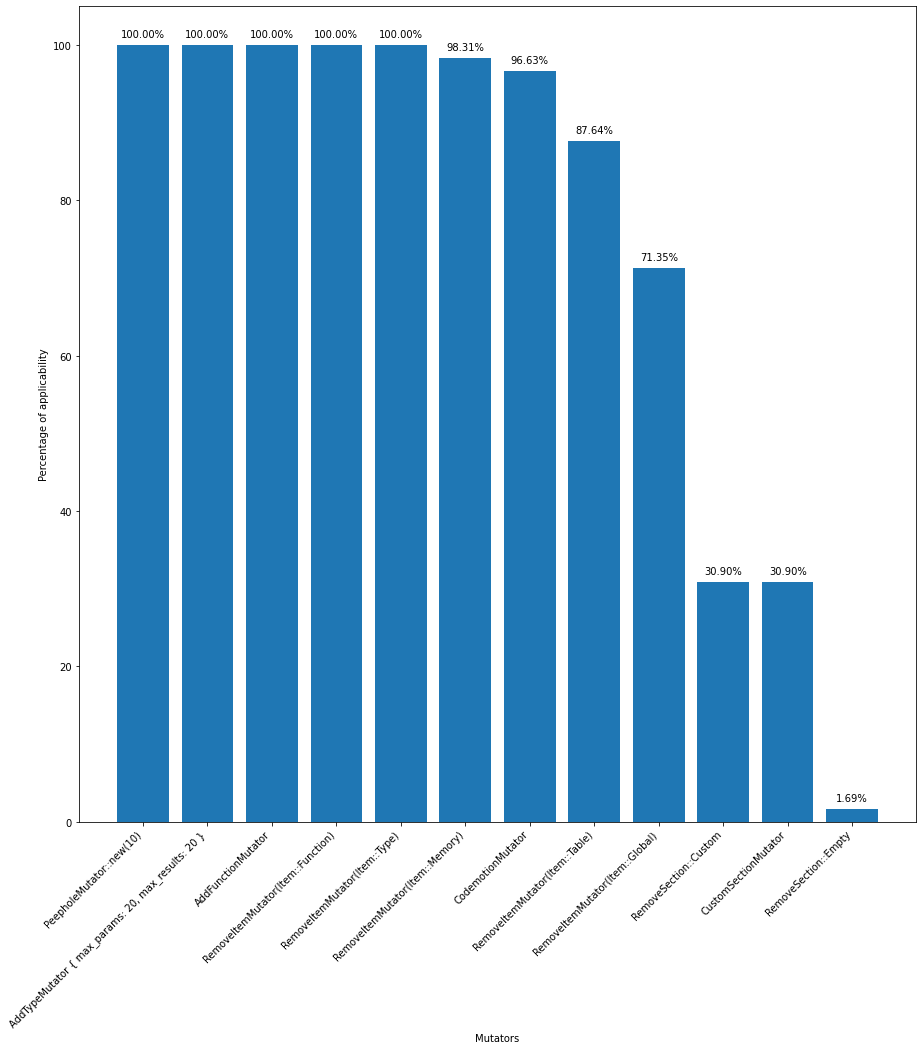

In [8]:
plot_bars(sets, total)

The previous figure can lead us to create the correct sort of 'configuration sets' according to the 'Swarm testing paper'

In [ ]:
import numpy as np

peep = sets[0]
randombin = peep[1][0]

print("Id", randombin['id'])

print(randombin['mutations'][0]['class_name'])
# List how the mutation can be applied
print(list(randombin['mutations'][0]['map'].values())[0][0]['how'])

operators_count = randombin['num_instructions']
mutations_count = len(randombin['mutations'][0]['map'].values())
peephole_mutability = mutations_count/operators_count

print(operators_count, mutations_count, peephole_mutability)

# get all posible peephole_mutations for this binary, in this function
def get_mutability(bininfo, key='Peephole'):
    operators_count = bininfo['num_instructions']
    # search the peephole mutation
    for m in bininfo['mutations']:
        if key in m['class_name']:
            if len(m['map']) == 2:
                mutations_count = m['map'][0]
            else:
                mutations_count = len(m['map'])
            break
            
    peephole_mutability = mutations_count/operators_count

    return peephole_mutability


allbins = [  ]

for s in sets:
    if 'Peephole' in s[0]:
        for b in s[1]:
            allbins.append(b)
        
mutabilities = [ get_mutability(b, key='Peephole') for b in allbins ]

print(len(mutabilities))


print("Mutability distribution for the peephole mutator")
plt.hist(mutabilities, bins=100)
plt.xticks(np.arange(0, 1, 0.1))
plt.xticks("Mutability percentage")
plt.yticks("Number of binaries in the class")

The peephole mmutator is able to mutate > ~27% of all instructions int he benchmark. At least 27/100 instructions are mutable in all binaries using the peephole mutator.

## Code motion mutability distribution

172
No mutable at all 0
No mutable loops 2
No mutable ifs 124


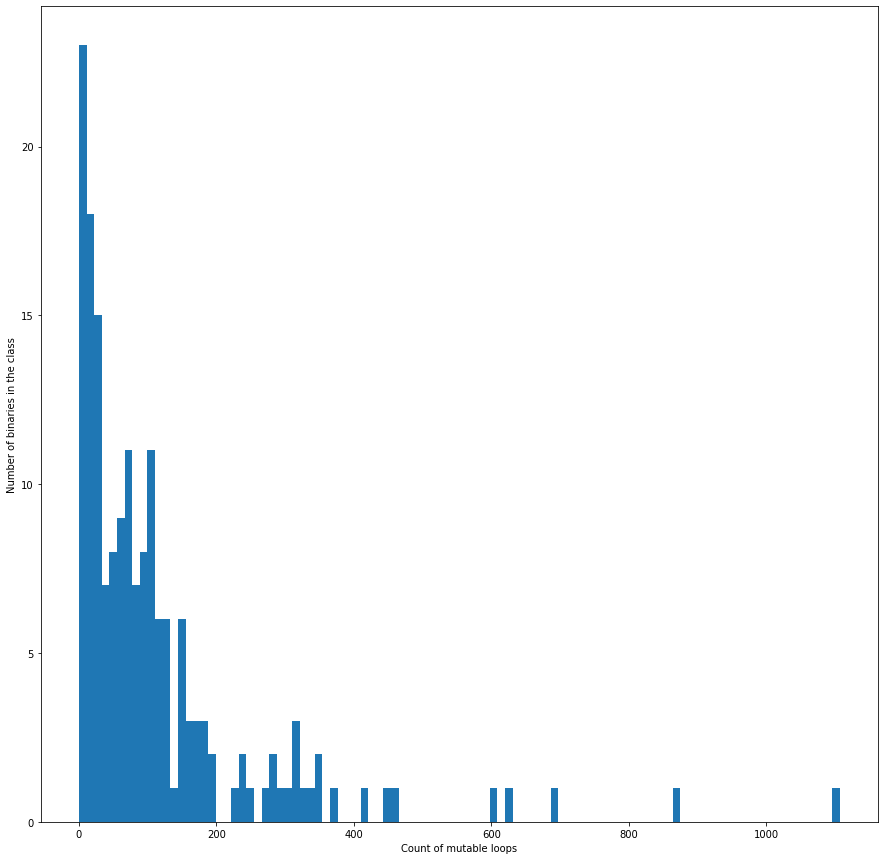

In [10]:
def get_mutable_type_distribution_for_code_motion(bininfo):
    operators_count = bininfo['num_instructions']
    # search the peephole mutation
    loops = 0
    ifs = 0
    
    for m in bininfo['mutations']:
        if 'Codemotion' in m['class_name']:
            for c in m['map'].values():
                for place in c:

                    if 'Invert' in place['how']:
                        ifs += 1
                    if 'Unroll' in place['how']:
                        loops += 1
            break
            
    return loops, ifs


allbins = [  ]

for s in sets:
    if 'Codemotion' in s[0]:
        for b in s[1]:
            allbins.append(b)

mutabilities = [ get_mutable_type_distribution_for_code_motion(b) for b in allbins ]

print(len(mutabilities))
plt.hist([x[0] for x in mutabilities], bins=100)
plt.xlabel("Count of mutable loops")
plt.ylabel("Number of binaries in the class")

print("No mutable at all", len([_ for x in mutabilities if x[0] == 0 and x[1] == 0]))
print("No mutable loops", len([_ for x in mutabilities if x[0] == 0 ]))
print("No mutable ifs", len([_ for x in mutabilities if x[1] == 0 ]))



As expected, there are many more loops than ifs. THe reason is that if constructions are really uncommon un Wasm. Instead, select is used since in the majority of the cases the blocks return a type. **TODO**, check for type returning blocks in all binaries

Text(0, 0.5, 'Number of binaries in the class')

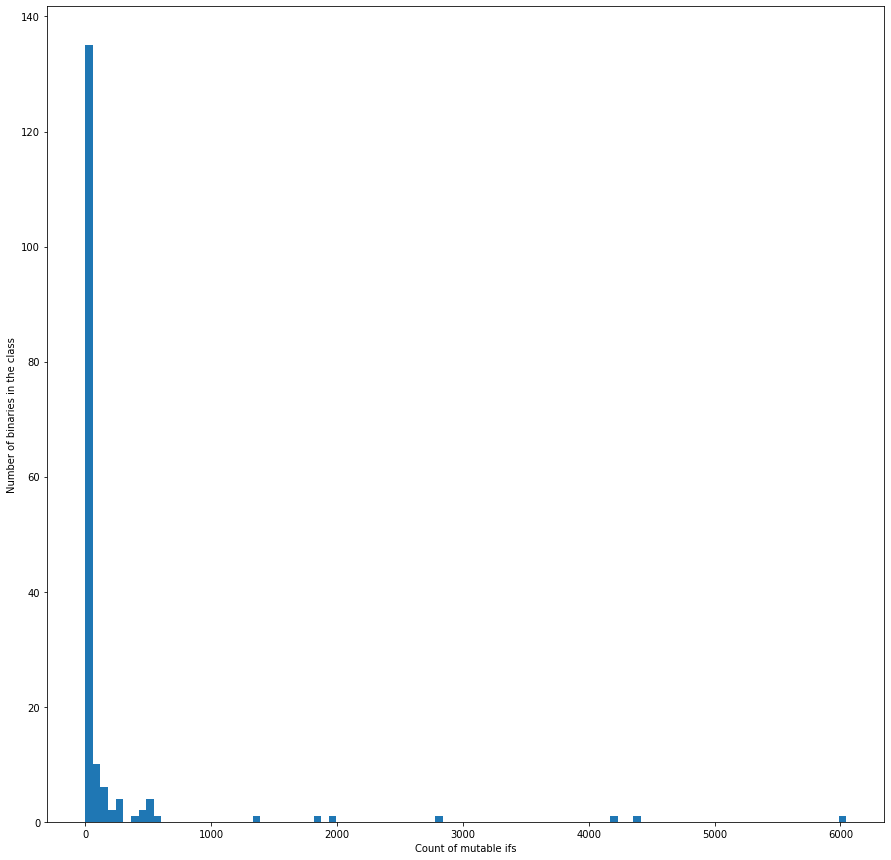

In [11]:

plt.hist([x[1] for x in mutabilities], bins=100)
plt.xlabel("Count of mutable ifs")
plt.ylabel("Number of binaries in the class")

Text(0, 0.5, 'Number of binaries in the class')

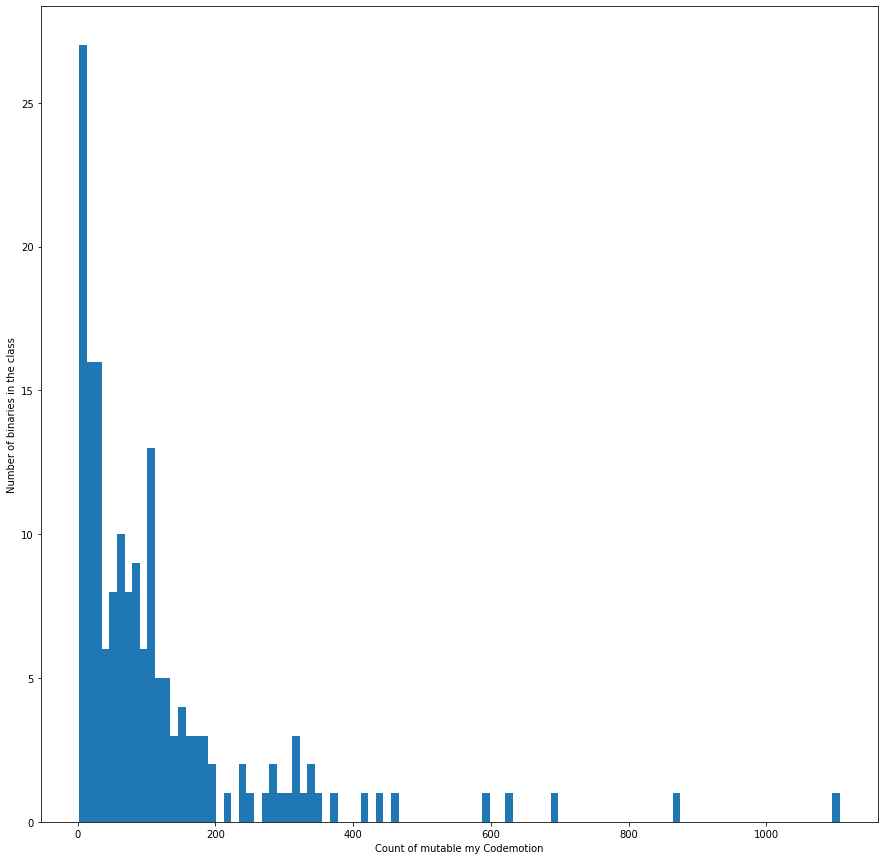

In [12]:

plt.hist([x[0] if x[0] > 0 else x[1] for x in mutabilities], bins=100)
plt.xlabel("Count of mutable my Codemotion")
plt.ylabel("Number of binaries in the class")

## Egraph stats

(array([93.,  8., 17., 26., 16.,  7.,  4.,  3.,  2.,  2.]),
 array([ 10. ,  25.1,  40.2,  55.3,  70.4,  85.5, 100.6, 115.7, 130.8,
        145.9, 161. ]),
 <BarContainer object of 10 artists>)

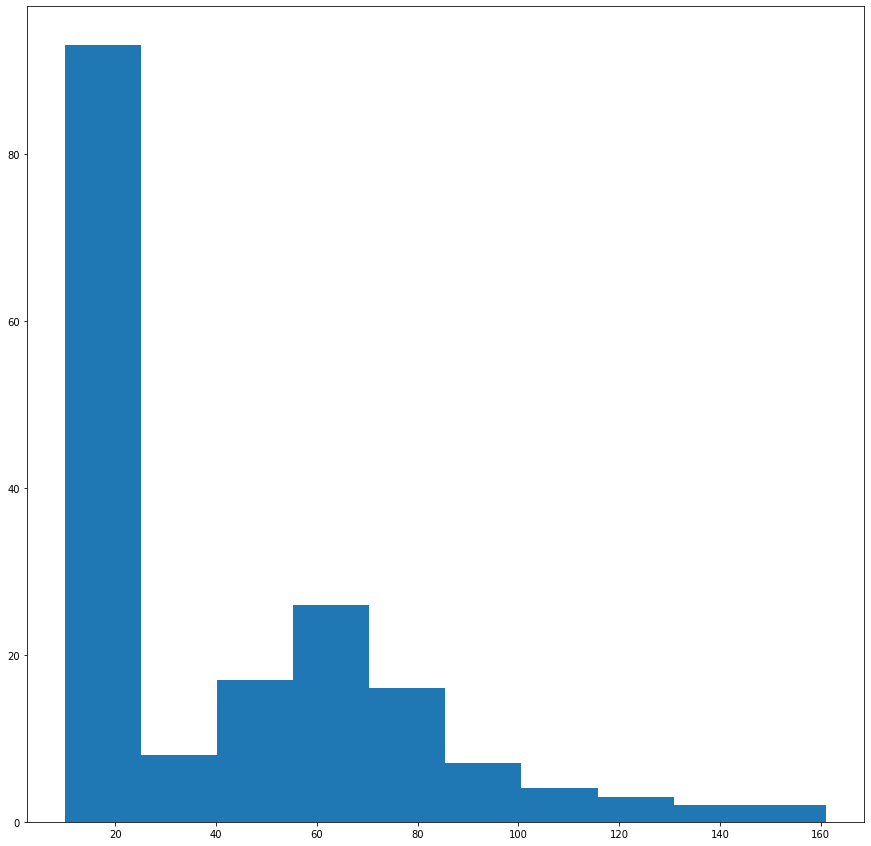

In [13]:
# get some stats on the egraphs of instructions
# get some stats on the profiling of mutable instructions. How many of the specification are we covering ?

# get all posible peephole_mutations for this binary, in this function
def get_egraphs_data(bininfo, key='Peephole'):
    operators_count = bininfo['num_instructions']
    # search the peephole mutation
    egraph_nodes = 0
    egraph_eclasses = 0
    
    for m in bininfo['mutations']:
        if key in m['class_name']:
            if len(m['map']) == 2:
                mutations_count = m['map'][0]
            else:
                for places in m['map'].values():
                    for place in places:
                        # print(place['meta'])
                        egraph_nodes = int(place['meta']['egraph_node_count'])
                        egraph_eclasses = int(place['meta']['egraph_eclass_count'])
            break
            

    return egraph_nodes, egraph_eclasses


allbins = [  ]

for s in sets:
    if 'Peephole' in s[0]:
        for b in s[1]:
            allbins.append(b)
            
egraphs_datas = [ get_egraphs_data(b) for b in allbins ]
xs = sorted([x[0] for x in egraphs_datas])
# Plot distribution of egraph node count
plt.hist(xs)


(array([ 1., 12., 83., 16., 30., 15.,  7.,  4.,  3.,  7.]),
 array([ 5. ,  6.1,  7.2,  8.3,  9.4, 10.5, 11.6, 12.7, 13.8, 14.9, 16. ]),
 <BarContainer object of 10 artists>)

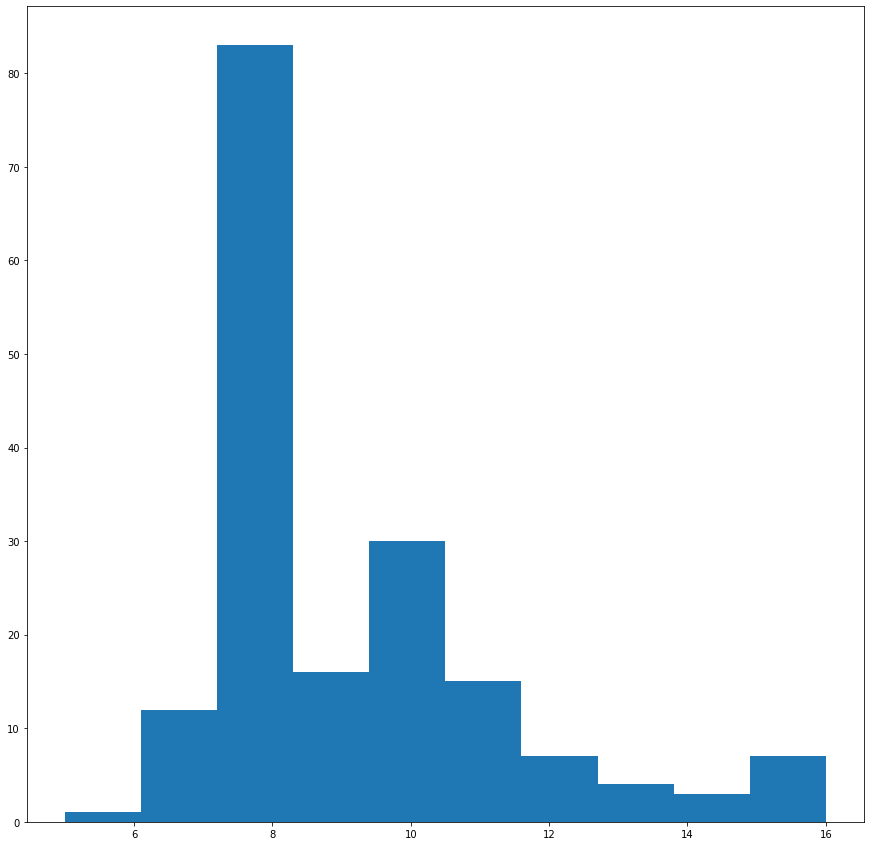

In [14]:

# Plot distribution of egraph eclass count
plt.hist([x[1] for x in egraphs_datas])